In [2]:
import pandas as pd
import gensim
import torch
import torch.nn as nn
import nltk
from nltk import word_tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F
import numpy as np
from torchmetrics.functional import f1

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-12-29 17:12:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.228.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.228.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.2MB/s    in 1m 41s  

2021-12-29 17:14:32 (15.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
df = pd.read_csv('Fake.csv')

Препроцессинг - в статье только приведение к нижнему регистру + паддинг, я добавила очистку от пунктуации, поскольку у нас не задача оценки тональности, и смайлики и прочее вряд ли сможет многое сказать о теме. И еще немного изменила паддинг (в оригинале паддилось до максимальной длины текста в трейне, но у нас макс. длина около 7800, а большая часть текстов длиной не превышает 512, поэтому буду обрезать и паддить до нее)

In [7]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

ls = []
cat_mapper = {cat: n for n, cat in enumerate(df.subject.unique())}
df.subject = df.subject.map(cat_mapper)
train_data, val_data = train_test_split(df, test_size=0.2, stratify=df.subject.values)
word_vocab = Counter()
for text in tqdm(df['text']):
    text = preprocess_text(text)
    word_vocab.update(text)
    #ls.append(len(text))
    
word2id = {'PAD':0}

for word in word_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

100%|██████████| 23481/23481 [01:13<00:00, 317.80it/s]


In [10]:
cat_mapper

{'Government News': 2,
 'Middle-east': 5,
 'News': 0,
 'US_News': 4,
 'left-news': 3,
 'politics': 1}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


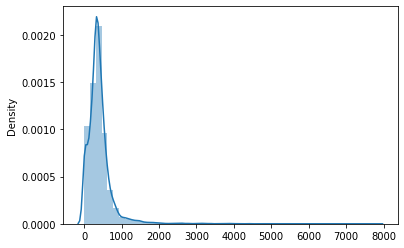

In [ ]:
sns_plot = sns.distplot(ls)
fig = sns_plot.get_figure()

In [ ]:
print(len(ls), max(ls))
print(len([l for l in ls if l <= 256]))
print(len([l for l in ls if l <= 512]))
print(len([l for l in ls if l <= 1024]))

23481 7815
6753
18325
22567


In [91]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['subject'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = preprocess_text(self.dataset[index])
        ids = [self.word2id[word] for word in words if word in self.word2id][:512]
        ids = F.pad(torch.LongTensor(ids), pad=(0, 512 - len(ids)))
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = torch.LongTensor(len(ids), 512)
      for i, id in enumerate(ids):
          padded_ids[i] = id
      y = torch.LongTensor(y).to(self.device)
      return padded_ids.to(self.device), y

In [92]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)
val_dataset = NewsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [35]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
        count += 1
        weights[i] = np.random.normal(-0.25,0.25,300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [96]:
class CLSTM(nn.Module):
    
    def __init__(self, vocab_size, cnn_n=[3], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 300)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=False)
        self.cnn_n = cnn_n
        if 2 in cnn_n:
            self.bigrams = nn.Conv1d(in_channels=300, out_channels=cnn_oc[cnn_n.index(2)], kernel_size=2, padding='valid')
        if 3 in cnn_n:
            self.trigrams = nn.Conv1d(in_channels=300, out_channels=cnn_oc[cnn_n.index(3)], kernel_size=3, padding='valid')
        if 4 in cnn_n:
            self.qgrams = nn.Conv1d(in_channels=300, out_channels=cnn_oc[cnn_n.index(4)], kernel_size=4, padding='valid')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=sum(cnn_oc), hidden_size=lstm_dim, num_layers=1, batch_first=True)
        self.dp_l = dp_l
        if dp_l !=0:
            self.dp = nn.Dropout(p=dp_p)
        self.linear = nn.Linear(lstm_dim, 6)

    def forward(self, n):
        embedded = self.embedding(n)
        if self.dp_l == 1:
            embedded = self.dp(embedded)
        embedded = embedded.transpose(1,2)
        feature_map_ngrams = []
        if 2 in self.cnn_n:
            feature_map_ngrams.append(self.relu(self.bigrams(embedded))[:,:,:511 - max(self.cnn_n)])
        if 3 in self.cnn_n:
            feature_map_ngrams.append(self.relu(self.trigrams(embedded))[:,:,:511 - max(self.cnn_n)])
        if 4 in self.cnn_n:
            feature_map_ngrams.append(self.relu(self.qgrams(embedded))[:,:,:511 - max(self.cnn_n)])
        if len(self.cnn_n) > 1:
            feature_map_ngrams = torch.cat(feature_map_ngrams, 1)
        else:
            feature_map_ngrams = feature_map_ngrams[0]
        out, (ht, ct) = self.lstm(feature_map_ngrams.transpose(1,2))
        if self.dp_l == 2:
            out = self.dp(ht[-1])
        out = self.linear(ht[-1])
        return out

In [122]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds,ys.squeeze())
            epoch_loss += loss.item()
            batch_metric = f1(preds, ys.squeeze(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [124]:
def get_results(epochs, train_iterator, val_iterator, ps, wd=0):

    model = CLSTM(len(word2id), **ps).to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.RMSprop(model.parameters(), weight_decay=wd)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []
    for i in tqdm(range(epochs)):
        print(f"\nParameters: cnn_n={ps['cnn_n']}, cnn_oc={ps['cnn_oc']}, lstm_dim={ps['lstm_dim']}, dp_l={ps['dp_l']}, dp_p={ps['dp_p']}, wd={wd}")
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
    return [losses, losses_eval, f1s, f1s_eval, ps, wd]

### Эксперименты

Dropout

1) dp_p = 0.5 - слишком большой

In [125]:
epochs = 2
ps = {'cnn_n': [3], 'cnn_oc':[150], 'lstm_dim':150, 'dp_l':1, 'dp_p':0.5}
res = []
res.append(get_results(2, train_iterator, val_iterator, ps, wd=0))

  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[3], cnn_oc=[150], lstm_dim=150, dp_l=1, dp_p=0.5, wd=0

starting Epoch 0
Training...
Train loss: 1.8231793391077142
Train loss: 1.6641193472820779
Train loss: 1.6130632175875537
Train loss: 1.593395657353587
Train loss: 1.5747657832802373

Evaluating on train...
Val loss: 1.5584880845588551, Val f1: 0.0008996851393021643
Val loss: 1.5411185824352762, Val f1: 0.000786936841905117
Val loss: 1.5328051141231736, Val f1: 0.0007983629475347698
Val loss: 1.5361631375886662, Val f1: 0.0008199083968065679
Val loss: 1.5386751560191383, Val f1: 0.0008423975668847561

Evaluating on test...
Val loss: 1.6881263256072998, Val f1: 0.0037523454520851374
Val loss: 1.59821946532638, Val f1: 0.0018066847696900368
Val loss: 1.5804642962246407, Val f1: 0.003773264354094863
Val loss: 1.561386589570479, Val f1: 0.0028127969708293676
Val loss: 1.556981995485831, Val f1: 0.0022420845925807953


 50%|█████     | 1/2 [03:47<03:47, 227.29s/it]


Parameters: cnn_n=[3], cnn_oc=[150], lstm_dim=150, dp_l=1, dp_p=0.5, wd=0

starting Epoch 1
Training...
Train loss: 1.5413716257664196
Train loss: 1.5220178904740707
Train loss: 1.521001260404642
Train loss: 1.5148339968223077
Train loss: 1.5195495063458346

Evaluating on train...
Val loss: 1.5541581166417975, Val f1: 0.0
Val loss: 1.538400241603022, Val f1: 0.0
Val loss: 1.534130353459044, Val f1: 0.0
Val loss: 1.5312199159102007, Val f1: 0.0
Val loss: 1.5254703677649317, Val f1: 0.0

Evaluating on test...
Val loss: 1.665473195222708, Val f1: 0.0
Val loss: 1.5781878851078175, Val f1: 0.0
Val loss: 1.5614723984788104, Val f1: 0.0
Val loss: 1.547856348211115, Val f1: 0.0
Val loss: 1.5445563758628955, Val f1: 0.0


100%|██████████| 2/2 [07:27<00:00, 223.66s/it]


2) Без дропаута наилучший размер фильтра - 2 (если мы берем только 1).

In [128]:
from itertools import product
params = list(product(*[[[2], [3], [4]], [[150]], [150], [0], [0]]))
for p in params:
    ps = {'cnn_n': p[0], 'cnn_oc':p[1], 'lstm_dim':p[2], 'dp_l':p[3], 'dp_p':p[4]}
    res.append(get_results(2, train_iterator, val_iterator, ps, wd=0))

  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 0
Training...
Train loss: 1.6204347673215365
Train loss: 1.4307504622832588
Train loss: 1.3494238440011967
Train loss: 1.3005870882566872
Train loss: 1.2634515015724208

Evaluating on train...
Val loss: 1.1571627321996187, Val f1: 0.44730624556541443
Val loss: 1.1634878272595612, Val f1: 0.4409838914871216
Val loss: 1.1697335015831656, Val f1: 0.43651482462882996
Val loss: 1.1695432851324865, Val f1: 0.4370649456977844
Val loss: 1.1705301581369552, Val f1: 0.436114102602005

Evaluating on test...
Val loss: 1.276118516921997, Val f1: 0.4792642295360565
Val loss: 1.225641617068538, Val f1: 0.45965734124183655
Val loss: 1.2141798691051762, Val f1: 0.4461507797241211
Val loss: 1.2000760089267384, Val f1: 0.4447583258152008
Val loss: 1.1947462316872417, Val f1: 0.4359973967075348


 50%|█████     | 1/2 [03:50<03:50, 230.17s/it]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 1
Training...
Train loss: 1.136707395838018
Train loss: 1.1044035217036372
Train loss: 1.0963394817589336
Train loss: 1.0880088380404882
Train loss: 1.0840885131829339

Evaluating on train...
Val loss: 1.1702074826809399, Val f1: 0.41323551535606384
Val loss: 1.1402857288070347, Val f1: 0.4184524714946747
Val loss: 1.1285957559684798, Val f1: 0.42537400126457214
Val loss: 1.1207973257803814, Val f1: 0.42713502049446106
Val loss: 1.1222960282774532, Val f1: 0.4241015911102295

Evaluating on test...
Val loss: 1.2449905092899616, Val f1: 0.48826950788497925
Val loss: 1.185607428903933, Val f1: 0.45434412360191345
Val loss: 1.1737534723630765, Val f1: 0.43727248907089233
Val loss: 1.165165254202756, Val f1: 0.4304657280445099
Val loss: 1.1625471391539643, Val f1: 0.4219287037849426


  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[3], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 0
Training...
Train loss: 1.783151243862353
Train loss: 1.6402744749318
Train loss: 1.5981140846461919
Train loss: 1.5743401205384886
Train loss: 1.5569198148060834

Evaluating on train...
Val loss: 1.5117364034318088, Val f1: 0.0
Val loss: 1.504624585483385, Val f1: 0.0004830917459912598
Val loss: 1.490907930225306, Val f1: 0.00032113035558722913
Val loss: 1.487953724799218, Val f1: 0.00024050023057498038
Val loss: 1.4833947890357575, Val f1: 0.00019223375420551747

Evaluating on test...
Val loss: 1.6210755018087535, Val f1: 0.0
Val loss: 1.5397642100298847, Val f1: 0.0018518517026677728
Val loss: 1.523275901631611, Val f1: 0.0012195120798423886
Val loss: 1.504959039254622, Val f1: 0.0009090907988138497
Val loss: 1.5014228250669397, Val f1: 0.0007246376480907202


 50%|█████     | 1/2 [03:26<03:26, 206.75s/it]


Parameters: cnn_n=[3], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 1
Training...
Train loss: 1.5234233329170628
Train loss: 1.50968512452167
Train loss: 1.5098171337491515
Train loss: 1.5042574658538357
Train loss: 1.4992981406644141

Evaluating on train...
Val loss: 1.8845572178823906, Val f1: 0.3677920997142792
Val loss: 1.8714682040007218, Val f1: 0.3639366924762726
Val loss: 1.8620321075351252, Val f1: 0.3634633719921112
Val loss: 1.8590424850389555, Val f1: 0.36378660798072815
Val loss: 1.8625789653883673, Val f1: 0.36166277527809143

Evaluating on test...
Val loss: 1.9703253507614136, Val f1: 0.40397459268569946
Val loss: 1.9021951269220423, Val f1: 0.38608163595199585
Val loss: 1.9000613776648916, Val f1: 0.37423545122146606
Val loss: 1.8734228112480857, Val f1: 0.3723181486129761
Val loss: 1.8841901378355164, Val f1: 0.36380335688591003


  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[4], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 0
Training...
Train loss: 1.7435541299351476
Train loss: 1.6224083216293999
Train loss: 1.572988622450415
Train loss: 1.5510893136391908
Train loss: 1.5416235932016868

Evaluating on train...
Val loss: 1.5865635244469893, Val f1: 0.370564728975296
Val loss: 1.5817232100859933, Val f1: 0.3628492057323456
Val loss: 1.5762792198644209, Val f1: 0.3632850646972656
Val loss: 1.573692452339899, Val f1: 0.36020609736442566
Val loss: 1.5723402029915252, Val f1: 0.36076247692108154

Evaluating on test...
Val loss: 1.6828917173238902, Val f1: 0.40397459268569946
Val loss: 1.622062572726497, Val f1: 0.38608163595199585
Val loss: 1.6066750491537698, Val f1: 0.37423545122146606
Val loss: 1.5926725084131415, Val f1: 0.3723181486129761
Val loss: 1.5937307122824849, Val f1: 0.36380335688591003


 50%|█████     | 1/2 [03:36<03:36, 216.45s/it]


Parameters: cnn_n=[4], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 1
Training...
Train loss: 1.4979146405270225
Train loss: 1.5064280582510907
Train loss: 1.5046119855318456
Train loss: 1.4989593921801745
Train loss: 1.4932330879785611

Evaluating on train...
Val loss: 1.5163015670943678, Val f1: 0.06286787241697311
Val loss: 1.5077804959338643, Val f1: 0.06238861382007599
Val loss: 1.5015716883488472, Val f1: 0.06039377301931381
Val loss: 1.4997474048044774, Val f1: 0.06187602877616882
Val loss: 1.4973584029913773, Val f1: 0.06356290727853775

Evaluating on test...
Val loss: 1.6028246329380915, Val f1: 0.07255629450082779
Val loss: 1.543387527819033, Val f1: 0.06897188723087311
Val loss: 1.5316799297565367, Val f1: 0.07033832371234894
Val loss: 1.5183872504667801, Val f1: 0.06902037560939789
Val loss: 1.5172853348911672, Val f1: 0.06750103831291199


100%|██████████| 2/2 [07:13<00:00, 216.55s/it]


In [130]:
#смотрим на наилучший f1 для каждого набора параметров, потому что модель после 1 эпохи результат может быть лучше, чем после 2
print(max(res, key=lambda x: max(x[3]))[-2])

{'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}


Добавим дропаут 0.2 для фильтра размера 2 и посмотрим, к какому слою лучше его добавить (или лучше вообще не добавлять)

In [131]:
params = list(product(*[[[2]], [[150]], [150], [1, 2], [0.2]]))
for p in params:
    ps = {'cnn_n': p[0], 'cnn_oc':p[1], 'lstm_dim':p[2], 'dp_l':p[3], 'dp_p':p[4]}
    res.append(get_results(2, train_iterator, val_iterator, ps, wd=0))

  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=1, dp_p=0.2, wd=0

starting Epoch 0
Training...
Train loss: 1.7611762410716008
Train loss: 1.6265043787334277
Train loss: 1.5965843069760097
Train loss: 1.5682155420253803
Train loss: 1.5559816046982076

Evaluating on train...
Val loss: 1.678742998524716, Val f1: 0.36492517590522766
Val loss: 1.6630892929823502, Val f1: 0.36542031168937683
Val loss: 1.6640241297683276, Val f1: 0.36316436529159546
Val loss: 1.6649450698456207, Val f1: 0.3618893623352051
Val loss: 1.6631632936042073, Val f1: 0.3615424335002899

Evaluating on test...
Val loss: 1.7971448348118708, Val f1: 0.40397459268569946
Val loss: 1.71622305004685, Val f1: 0.38608163595199585
Val loss: 1.701114660356103, Val f1: 0.37423545122146606
Val loss: 1.6852057521993464, Val f1: 0.3723181486129761
Val loss: 1.6856595018635625, Val f1: 0.36380335688591003


 50%|█████     | 1/2 [03:49<03:49, 229.51s/it]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=1, dp_p=0.2, wd=0

starting Epoch 1
Training...
Train loss: 1.5308623125678615
Train loss: 1.5246384019437043
Train loss: 1.5192750609679029
Train loss: 1.507455243176712
Train loss: 1.5075171975528492

Evaluating on train...
Val loss: 1.514417566751179, Val f1: 0.3607430160045624
Val loss: 1.4955831081970878, Val f1: 0.3630949556827545
Val loss: 1.4874246630365449, Val f1: 0.3662201166152954
Val loss: 1.4876768774800486, Val f1: 0.3625134825706482
Val loss: 1.4879205024778637, Val f1: 0.36003273725509644

Evaluating on test...
Val loss: 1.6062140556482167, Val f1: 0.40416419506073
Val loss: 1.535367418218542, Val f1: 0.38505756855010986
Val loss: 1.5224152628968401, Val f1: 0.37239423394203186
Val loss: 1.5075644167986784, Val f1: 0.36989179253578186
Val loss: 1.505488257477249, Val f1: 0.361837238073349


  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=2, dp_p=0.2, wd=0

starting Epoch 0
Training...
Train loss: 1.7804337070699323
Train loss: 1.6261687237283458
Train loss: 1.5854739033417895
Train loss: 1.5694492167724676
Train loss: 1.5577265869787407

Evaluating on train...
Val loss: 1.5606246642899095, Val f1: 0.3743458390235901
Val loss: 1.5461840049080227, Val f1: 0.3602447807788849
Val loss: 1.5383370818430289, Val f1: 0.359679251909256
Val loss: 1.5377224136740615, Val f1: 0.35815373063087463
Val loss: 1.530683663889611, Val f1: 0.36168065667152405

Evaluating on test...
Val loss: 1.643444611476018, Val f1: 0.40307503938674927
Val loss: 1.5696045645961054, Val f1: 0.3850324749946594
Val loss: 1.5656444939171397, Val f1: 0.3731420338153839
Val loss: 1.544298687848178, Val f1: 0.3715030550956726
Val loss: 1.5487075197523918, Val f1: 0.3631536364555359


 50%|█████     | 1/2 [03:27<03:27, 207.16s/it]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=2, dp_p=0.2, wd=0

starting Epoch 1
Training...
Train loss: 1.5159961549859298
Train loss: 1.5200906743174014
Train loss: 1.512688124110933
Train loss: 1.5067447945153043
Train loss: 1.498604822736298

Evaluating on train...
Val loss: 1.530654788017273, Val f1: 0.348596453666687
Val loss: 1.5170829845511395, Val f1: 0.34907129406929016
Val loss: 1.5101936855757168, Val f1: 0.3511876165866852
Val loss: 1.5086731337881707, Val f1: 0.35204648971557617
Val loss: 1.5087646530573755, Val f1: 0.3488583266735077

Evaluating on test...
Val loss: 1.630091016109173, Val f1: 0.4030924141407013
Val loss: 1.5622203924037792, Val f1: 0.3755277097225189
Val loss: 1.5489345818031124, Val f1: 0.35987862944602966
Val loss: 1.5322901075536555, Val f1: 0.35528236627578735
Val loss: 1.5307380202887715, Val f1: 0.34522905945777893


100%|██████████| 2/2 [06:55<00:00, 207.55s/it]


Лучше без дропаута

In [132]:
print(max(res, key=lambda x: max(x[3]))[-2])

{'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}


Посмотрим, что будет, если вместо дропаута добавить l2-регуляризацию

In [133]:
from itertools import product
params = list(product(*[[[2]], [[150]], [150], [0], [0]]))
for p in params:
    ps = {'cnn_n': p[0], 'cnn_oc':p[1], 'lstm_dim':p[2], 'dp_l':p[3], 'dp_p':p[4]}
    res.append(get_results(2, train_iterator, val_iterator, ps, wd=0.001))
print(max(res, key=lambda x: max(x[3]))[-2])

  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0.001

starting Epoch 0
Training...
Train loss: 1.6701966001276385
Train loss: 1.4578872302304144
Train loss: 1.3081127577434386
Train loss: 1.2429859067970541
Train loss: 1.202455156402192

Evaluating on train...
Val loss: 1.409546084571303, Val f1: 0.06628016382455826
Val loss: 1.3973092991372813, Val f1: 0.06377993524074554
Val loss: 1.3976048155327063, Val f1: 0.06289569288492203
Val loss: 1.3946934365606927, Val f1: 0.06287463754415512
Val loss: 1.3933884025032546, Val f1: 0.06397398561239243

Evaluating on test...
Val loss: 1.5180768874975352, Val f1: 0.05214604362845421
Val loss: 1.4457019920702334, Val f1: 0.06966851651668549
Val loss: 1.4289297970329844, Val f1: 0.07257040590047836
Val loss: 1.4160482428290628, Val f1: 0.06884511560201645
Val loss: 1.4127609021421792, Val f1: 0.06519079208374023


 50%|█████     | 1/2 [03:40<03:40, 220.82s/it]


Parameters: cnn_n=[2], cnn_oc=[150], lstm_dim=150, dp_l=0, dp_p=0, wd=0.001

starting Epoch 1
Training...
Train loss: 1.0914855860827262
Train loss: 1.0453127207963362
Train loss: 1.0236635015189992
Train loss: 1.0074428162533484
Train loss: 1.0048687604471886

Evaluating on train...
Val loss: 0.9322593368982014, Val f1: 0.45608171820640564
Val loss: 0.9573889079301253, Val f1: 0.43504032492637634
Val loss: 0.9531459077934309, Val f1: 0.4324910640716553
Val loss: 0.9542001003310794, Val f1: 0.4339636266231537
Val loss: 0.954907574043142, Val f1: 0.434422105550766

Evaluating on test...
Val loss: 1.054551784808819, Val f1: 0.4950578510761261
Val loss: 1.01061350107193, Val f1: 0.4662399888038635
Val loss: 1.004414373781623, Val f1: 0.44722551107406616
Val loss: 0.9913714668967507, Val f1: 0.44063645601272583
Val loss: 0.9867152934489043, Val f1: 0.4310884475708008


100%|██████████| 2/2 [07:10<00:00, 215.30s/it]

{'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}


In [135]:
print(max(res, key=lambda x: max(x[3]))[-1])

0


Лучше без нее.
Теперь посмотрим, что будет, если взять фильтры разной длины

In [136]:
from itertools import product
params = list(product(*[[[2, 3, 4]], [[300, 150, 150]], [150], [0], [0]]))
for p in params:
    ps = {'cnn_n': p[0], 'cnn_oc':p[1], 'lstm_dim':p[2], 'dp_l':p[3], 'dp_p':p[4]}
    res.append(get_results(2, train_iterator, val_iterator, ps, wd=0))
print(max(res, key=lambda x: max(x[3]))[-2])

  0%|          | 0/2 [00:00<?, ?it/s]


Parameters: cnn_n=[2, 3, 4], cnn_oc=[300, 150, 150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 0
Training...
Train loss: 1.7714566536117018
Train loss: 1.6326789990715358
Train loss: 1.578915651823055
Train loss: 1.5571203959452642
Train loss: 1.5487697875210984

Evaluating on train...
Val loss: 1.4756701745485004, Val f1: 0.04752263054251671
Val loss: 1.4633225980012312, Val f1: 0.04569309949874878
Val loss: 1.4652783064483907, Val f1: 0.04531539976596832
Val loss: 1.4641246589231285, Val f1: 0.04654628038406372
Val loss: 1.4609148605472075, Val f1: 0.04742711782455444

Evaluating on test...
Val loss: 1.5789182552924523, Val f1: 0.0346103198826313
Val loss: 1.508352447439123, Val f1: 0.0473824217915535
Val loss: 1.4962498996315934, Val f1: 0.05701269581913948
Val loss: 1.4777686140754007, Val f1: 0.05819550156593323
Val loss: 1.4775391989859983, Val f1: 0.05619310960173607


 50%|█████     | 1/2 [04:28<04:28, 268.24s/it]


Parameters: cnn_n=[2, 3, 4], cnn_oc=[300, 150, 150], lstm_dim=150, dp_l=0, dp_p=0, wd=0

starting Epoch 1
Training...
Train loss: 1.5409216608917504
Train loss: 1.5243809088416722
Train loss: 1.5100436872140521
Train loss: 1.5009611839855903
Train loss: 1.494821298493646

Evaluating on train...
Val loss: 1.48775739627972, Val f1: 0.3553099036216736
Val loss: 1.4737987134767616, Val f1: 0.3521776497364044
Val loss: 1.4691219116221963, Val f1: 0.3465982973575592
Val loss: 1.4697357085876135, Val f1: 0.3442956209182739
Val loss: 1.4676336417148683, Val f1: 0.3494608998298645

Evaluating on test...
Val loss: 1.5735998887282152, Val f1: 0.39856719970703125
Val loss: 1.5054659446080525, Val f1: 0.3725178837776184
Val loss: 1.4981483366431259, Val f1: 0.3597758114337921
Val loss: 1.4826057715849443, Val f1: 0.35674336552619934
Val loss: 1.485050298165584, Val f1: 0.3469614088535309


100%|██████████| 2/2 [08:40<00:00, 260.44s/it]

{'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}


### Итоги

Параметры по мере убывания:

In [141]:
print(('\n').join([str((e[-2], e[-1], e[3])) for e in sorted(res, reverse=True, key=lambda x: max(x[3]))]))

({'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}, 0, [tensor(0.4314, device='cuda:0'), tensor(0.4189, device='cuda:0')])
({'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}, 0.001, [tensor(0.0642, device='cuda:0'), tensor(0.4273, device='cuda:0')])
({'cnn_n': [3], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}, 0, [tensor(0.0007, device='cuda:0'), tensor(0.3597, device='cuda:0')])
({'cnn_n': [4], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}, 0, [tensor(0.3597, device='cuda:0'), tensor(0.0647, device='cuda:0')])
({'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 1, 'dp_p': 0.2}, 0, [tensor(0.3597, device='cuda:0'), tensor(0.3578, device='cuda:0')])
({'cnn_n': [2], 'cnn_oc': [150], 'lstm_dim': 150, 'dp_l': 2, 'dp_p': 0.2}, 0, [tensor(0.3591, device='cuda:0'), tensor(0.3414, device='cuda:0')])
({'cnn_n': [2, 3, 4], 'cnn_oc': [300, 150, 150], 'lstm_dim': 150, 'dp_l': 0, 'dp_p': 0}, 0, [tensor(0.0544, device='cuda:0'), te

Вероятно, результаты не такие большие, поскольку слишком мало эпох, и из-за этого же не понадобились регуляризация и дропауты (хотя видно, что даже так в некоторых случаях модель переобучилась, возможно, стоит просто еще уменьшить dp и wd). Но с заданным количеством эпох лучше всего брать только 1 фильтр, размером 2 без дропаутов и регуляризации